In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [115]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import re
import seaborn as sns
from pprint import pprint

In [147]:
sns.set_style('darkgrid')
sns.set_context("paper")
sns.set(font='serif')
sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
})
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', None)

In [117]:
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report

In [118]:
df = pd.read_csv('../data/processed/stage4_moreNLP_labels.csv')

In [119]:
df.columns

Index(['Unnamed: 0', 'songid', 'spotify_track_id', 'artist_genre',
       'spotify_track_duration_ms', 'spotify_track_popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'performer', 'song', 'lyrics', 'peak_position', 'weeks_on_chart',
       'instance', 'lyrics_proc', 'word_count', 'vocab_count', 'lex_div',
       'sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'sentiment_val',
       'weekid', 'year', 'month', 'hit'],
      dtype='object')

In [120]:
cols = ['spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness', 
        'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
        'valence', 'tempo', 'time_signature', 'lex_div', 'sentiment_pos', 
        'sentiment_neg', 'sentiment_neu', 'sentiment_val'] 
X = df[cols]
y = df['hit']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [122]:
clf = BalancedRandomForestClassifier(n_estimators=800, min_samples_split=2, 
                                     min_samples_leaf=1, max_features='auto', 
                                     max_depth=100, bootstrap=True, random_state=0)
clf.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                               criterion='gini', max_depth=100,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=1,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=800,
                               n_jobs=1, oob_score=False, random_state=0,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [123]:
y_pred = clf.predict(X_test)
balanced_accuracy_score(y_test, y_pred) 

0.6633660422242046

In [124]:
confusion_matrix(y_test, y_pred)

array([[220, 134],
       [ 28,  67]])

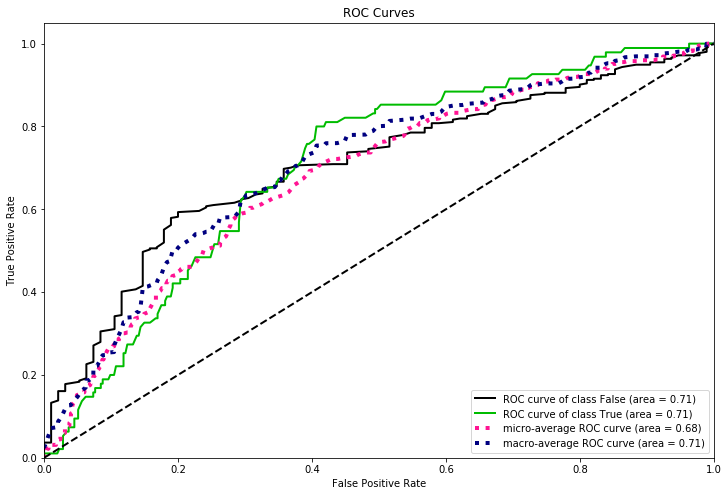

In [125]:
predicted_probas = clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.62      0.73       354
        True       0.33      0.71      0.45        95

    accuracy                           0.64       449
   macro avg       0.61      0.66      0.59       449
weighted avg       0.77      0.64      0.67       449



In [127]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [24]:
clf_random = RandomizedSearchCV(estimator=clf, 
                                param_distributions=random_grid, 
                                n_iter=100, cv=3, verbose=2, random_state=42, 
                                n_jobs = -1)# Fit the random search model
clf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BalancedRandomForestClassifier(bootstrap=True,
                                                            class_weight=None,
                                                            criterion='gini',
                                                            max_depth=None,
                                                            max_features='auto',
                                                            max_leaf_nodes=None,
                                                            min_impurity_decrease=0.0,
                                                            min_samples_leaf=2,
                                                            min_samples_split=2,
                                                            min_weight_fraction_leaf=0.0,
                                                            n_estimators=50,
                                                        

In [33]:
clf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [34]:
clf_random.best_score_

0.6228412256267409

## AdaBoost

In [132]:
clf = RUSBoostClassifier(n_estimators=250, learning_rate=.1, random_state=0)
clf.fit(X_train, y_train)

RUSBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=250, random_state=0, replacement=False,
                   sampling_strategy='auto')

In [133]:
y_pred = clf.predict(X_test)
balanced_accuracy_score(y_test, y_pred) 

0.6246060065417782

In [134]:
confusion_matrix(y_test, y_pred)

array([[241, 113],
       [ 41,  54]])

In [135]:
len(y_test)

449

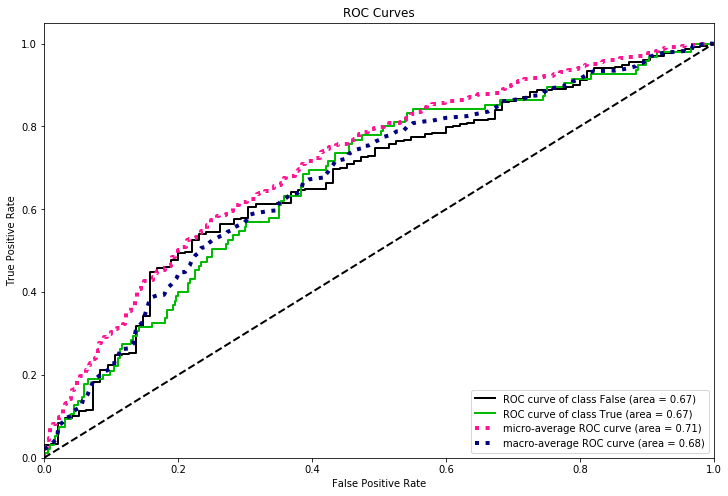

In [136]:
predicted_probas = clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()

In [137]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.85      0.68      0.76       354
        True       0.32      0.57      0.41        95

    accuracy                           0.66       449
   macro avg       0.59      0.62      0.59       449
weighted avg       0.74      0.66      0.68       449



In [138]:
clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 0.1,
 'n_estimators': 250,
 'random_state': 0,
 'replacement': False,
 'sampling_strategy': 'auto'}

In [50]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
learning_rate = [float(x) for x in np.linspace(.01, 2.0, num = 21)]
replacement = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'replacement': replacement}
pprint(random_grid)

{'learning_rate': [0.01,
                   0.1095,
                   0.20900000000000002,
                   0.3085,
                   0.40800000000000003,
                   0.5075000000000001,
                   0.607,
                   0.7065,
                   0.806,
                   0.9055000000000001,
                   1.0050000000000001,
                   1.1045,
                   1.204,
                   1.3035,
                   1.403,
                   1.5025000000000002,
                   1.602,
                   1.7015,
                   1.8010000000000002,
                   1.9005,
                   2.0],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'replacement': [True, False]}


In [51]:
clf_random = RandomizedSearchCV(estimator=clf, 
                                param_distributions=random_grid, 
                                n_iter=100, cv=3, verbose=2, random_state=42, 
                                n_jobs = -1)# Fit the random search model
clf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RUSBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=200,
                                                random_state=0,
                                                replacement=False,
                                                sampling_strategy='auto'),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1095,
                                                          0.20900000000000002,
                                                          0.3085,
                                                          0.40800000000000003,
                                                          0.5075000000000001,
                                     

In [52]:
clf_random.best_params_

{'replacement': False, 'n_estimators': 1800, 'learning_rate': 1.3035}

# XGBoost

In [139]:
from xgboost import XGBClassifier

In [140]:
clf = XGBClassifier(n_estimators=680, scale_pos_weight=3.5, 
                    learning_rate=0.03, max_depth=1, min_child_weight=1, replacement=True)

In [141]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=680, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, replacement=True, scale_pos_weight=3.5,
              seed=None, silent=None, subsample=1, verbosity=1)

In [142]:
y_pred = clf.predict(X_test)
balanced_accuracy_score(y_test, y_pred) 

0.6446327683615819

In [143]:
confusion_matrix(y_test, y_pred)

array([[244, 110],
       [ 38,  57]])

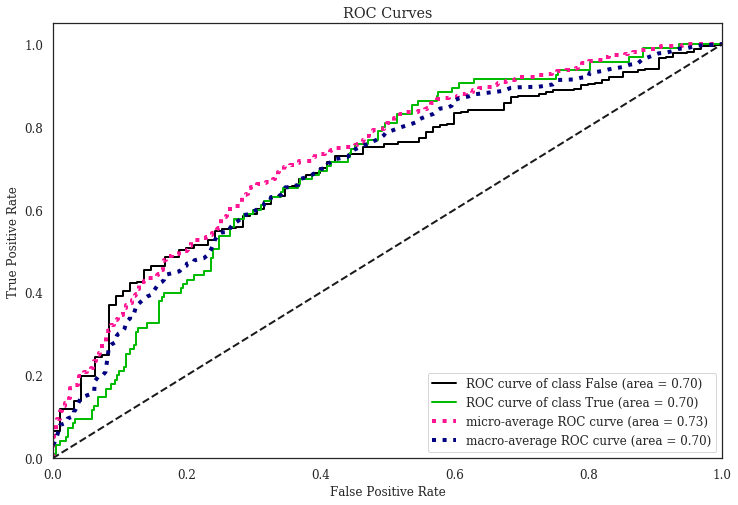

In [148]:
predicted_probas = clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()

In [145]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.69      0.77       354
        True       0.34      0.60      0.44        95

    accuracy                           0.67       449
   macro avg       0.60      0.64      0.60       449
weighted avg       0.75      0.67      0.70       449



In [89]:
clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.08,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 680,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 3.5,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1,
 'replacement': True}

In [111]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), cols), 
             reverse=True))

Features sorted by their score:
[(0.13, 'lex_div'), (0.118, 'valence'), (0.106, 'liveness'), (0.1, 'speechiness'), (0.07, 'energy'), (0.066, 'spotify_track_duration_ms'), (0.062, 'tempo'), (0.052, 'danceability'), (0.05, 'sentiment_pos'), (0.05, 'sentiment_neg'), (0.04, 'loudness'), (0.04, 'acousticness'), (0.038, 'sentiment_neu'), (0.036, 'sentiment_val'), (0.032, 'instrumentalness'), (0.006, 'key'), (0.004, 'time_signature'), (0.0, 'mode')]


In [81]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 11)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 6, num = 5)]
min_child_weight = [int(x) for x in np.linspace(start = 1, stop = 6, num = 5)]
learning_rate = [float(x) for x in np.linspace(.01, .10, num=10)]
replacement = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'learning_rate': learning_rate,
               'replacement': replacement}
pprint(random_grid)

{'learning_rate': [0.01,
                   0.020000000000000004,
                   0.030000000000000006,
                   0.04000000000000001,
                   0.05000000000000001,
                   0.06000000000000001,
                   0.07,
                   0.08,
                   0.09000000000000001,
                   0.1],
 'max_depth': [1, 2, 3, 4, 6],
 'min_child_weight': [1, 2, 3, 4, 6],
 'n_estimators': [200, 280, 360, 440, 520, 600, 680, 760, 840, 920, 1000],
 'replacement': [True, False]}


In [82]:
clf_random = RandomizedSearchCV(estimator=clf, 
                                param_distributions=random_grid, 
                                n_iter=100, cv=3, verbose=2, random_state=42, 
                                n_jobs = -1)# Fit the random search model
clf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=1, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=...
                                                          0.030000000000000006,
                                                          0.04000000000000001,
                                                          0.050

In [83]:
clf_random.best_params_

{'replacement': True,
 'n_estimators': 680,
 'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.08}